In [1]:
import numpy as np
from einops import rearrange

from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity

import os

In [2]:
 # HARDCODED FOR LLAVA
num_heads_llm = 40
num_layers_llm = 40

In [3]:
base_dir = 'vgr_probing/features_bias_2/train'
val_ratio = 0.2
n_samples = 200

In [4]:
head_truth = np.load(os.path.join(base_dir, "truth", f"head_wise_{n_samples}_llm.npy"))
print(head_truth.shape)
head_truth = rearrange(head_truth, 'b l (h d) -> b l h d', h = num_heads_llm)

head_bias = np.load(os.path.join(base_dir, "bias", f"head_wise_{n_samples}_llm.npy"))
print(head_bias.shape)
head_bias = rearrange(head_bias, 'b l (h d) -> b l h d', h = num_heads_llm)

labels_truth = np.load(os.path.join(base_dir, "truth", f"labels_{n_samples}.npy"))
labels_bias = np.load(os.path.join(base_dir, "bias", f"labels_{n_samples}.npy"))

print(head_truth.shape, head_bias.shape)

(200, 40, 5120)
(200, 40, 5120)
(200, 40, 40, 128) (200, 40, 40, 128)


In [5]:
print(np.unique(labels_truth), np.unique(labels_bias))

[0 1] [2 3]


## Lets analyze the accuracy

In [6]:
def get_performance_dict(X, y, num_layers, num_heads):
    head_perf_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)}
    for l in tqdm(range(num_layers)):
        for h in range(num_heads):
            X_probe = X[:, l, h, :]
            y_probe = y[:]
            _, val_acc = train_single_prob(X_probe, y_probe, val_size=val_ratio)
            head_perf_dict[f'l{l}_h{h}'] = val_acc
    return head_perf_dict

In [7]:
def get_perf_array(X_all, y_all, num_layers, num_heads):
    head_perf_dict = get_performance_dict(X_all, y_all, num_layers, num_heads)
    l_h_means = np.array(list(head_perf_dict.values())).reshape(num_layers, num_heads) # row = heads | colums = layers
    return l_h_means

In [8]:
perf = get_perf_array(np.vstack((head_bias,head_truth)), np.hstack((labels_bias, labels_truth)), num_layers_llm, num_heads_llm)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:27<00:00,  1.48it/s]


/tmp/ipykernel_316457/1397437595.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


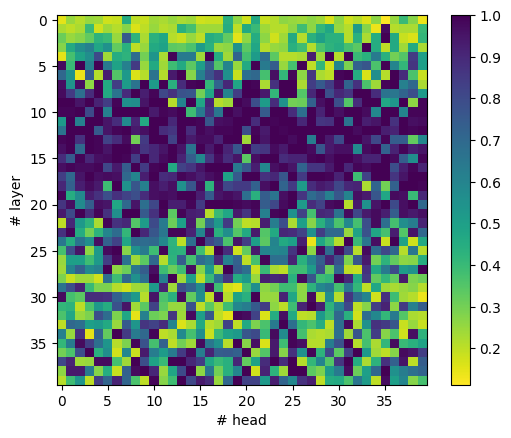

In [9]:
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 

plt.imshow(perf, cmap = reversed_map)
plt.colorbar()
plt.xlabel('# head')
plt.ylabel('# layer')
plt.show()